In [ ]:
# ═══════════════════════════════════════════════
# 1. Librerías estándar y configuración general
# ═══════════════════════════════════════════════
import os
import sys
import ast
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

# ═══════════════════════════════════════════════
# 2. Preprocesamiento y ML clásico
# ═══════════════════════════════════════════════
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MultiLabelBinarizer
)
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
from scipy.stats import randint, uniform

# ═══════════════════════════════════════════════
# 3. Modelos
# ═══════════════════════════════════════════════
from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# ═══════════════════════════════════════════════
# 4. Persistencia y utilidades del proyecto
# ═══════════════════════════════════════════════
from joblib import dump
from new_or_used import build_dataset  # función provista para cargar datos

# ═══════════════════════════════════════════════
# 5. MLflow tracking
# ═══════════════════════════════════════════════
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri("file:../Experiments")

/opt/anaconda3/envs/sumz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Cargar los datasets preprocesados
X_train = pd.read_csv("../Data/Gold/X_train_gold.csv")
X_test = pd.read_csv("../Data/Gold/X_test_gold.csv")
y_train = pd.read_csv("../Data/Gold/y_train_gold.csv")
y_test = pd.read_csv("../Data/Gold/y_test_gold.csv")

y_test.rename(columns={'0': 'condition'}, inplace=True)

y_train_final = y_train["condition"].map({"used": 0, "new": 1})
y_test_final = y_test["condition"].map({"used": 0, "new": 1})


print("Datasets cargados correctamente.")

Datasets cargados correctamente.


🏆 Comparativa de modelos por accuracy y ROC AUC:
                 experiment_name               run_name  accuracy   roc_auc
2             XGBoost_Experiment                XGBoost    0.9021  0.966328
0      Neural_Network_Experiment          NeuralNetwork    0.8677  0.938004
1  LogisticRegression_Experiment  LogisticRegression_CV    0.8488  0.920851

📌 Evaluando modelo 'XGBoost' (XGBoost_Experiment) — Accuracy real: 0.9021


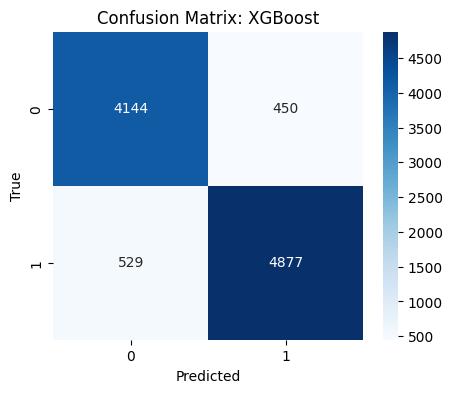

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      4594
           1       0.92      0.90      0.91      5406

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

⚠️ No se pudo cargar modelo del run ade1c547d19d41e69dc42bfddb3f427c: columns are missing: {'city_grouped'}

📌 Evaluando modelo 'LogisticRegression_CV' (LogisticRegression_Experiment) — Accuracy real: 0.8488


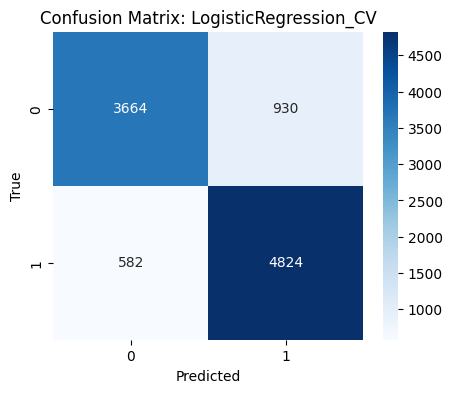

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      4594
           1       0.84      0.89      0.86      5406

    accuracy                           0.85     10000
   macro avg       0.85      0.84      0.85     10000
weighted avg       0.85      0.85      0.85     10000

✅ Modelo guardado en ./Models/best_model_production.pkl


In [ ]:

client = MlflowClient()

experiments = mlflow.search_experiments()
all_runs = []

for exp in experiments:
    runs = client.search_runs(
        experiment_ids=[exp.experiment_id],
        filter_string="attributes.status = 'FINISHED'"
    )
    for run in runs:
        all_runs.append({
            "run_id": run.info.run_id,
            "experiment_name": exp.name,
            "run_name": run.data.tags.get("mlflow.runName", None),
            "accuracy": run.data.metrics.get("accuracy", None),
            "roc_auc": run.data.metrics.get("roc_auc", None)
        })

df = pd.DataFrame(all_runs)
df_filtered = df.dropna(subset=["accuracy", "roc_auc"])
df_sorted = df_filtered.sort_values(by=["accuracy", "roc_auc"], ascending=False)

print("🏆 Comparativa de modelos por accuracy y ROC AUC:")
print(df_sorted[["experiment_name", "run_name", "accuracy", "roc_auc"]].head(10))

# === Evaluar cada modelo detectando el nombre real del artefacto
best_model = None
best_accuracy = -1

for idx, row in df_sorted.iterrows():
    run_id = row["run_id"]
    run_name = row["run_name"]
    experiment_name = row["experiment_name"]

    try:
        # Detectar los artefactos del run
        artifacts = client.list_artifacts(run_id)
        model_names = [a.path for a in artifacts if a.is_dir]

        if not model_names:
            raise ValueError("⚠️ No se encontró ningún modelo registrado en este run.")

        # Usar el primer modelo registrado (o podrías filtrarlos por nombre si lo prefieres)
        model_uri = f"runs:/{run_id}/{model_names[0]}"
        model = mlflow.sklearn.load_model(model_uri)

        y_pred = model.predict(X_test)
        acc = (y_pred == y_test_final).mean()

        print(f"\n📌 Evaluando modelo '{run_name}' ({experiment_name}) — Accuracy real: {acc:.4f}")

        cm = confusion_matrix(y_test_final, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
        plt.title(f"Confusion Matrix: {run_name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

        print(classification_report(y_test_final, y_pred))

        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model

    except Exception as e:
        print(f"⚠️ No se pudo cargar modelo del run {run_id}: {e}")

if best_model:
    os.makedirs("../Models", exist_ok=True)
    dump(best_model, "../Models/best_model_production.pkl")
    print("✅ Modelo guardado en ./Models/best_model_production.pkl")
else:
    print("❌ No se pudo guardar ningún modelo.")